In [125]:
import os
import cv2
import json
import numpy as np
from pathlib import Path
from random import randint
import matplotlib.pyplot as plt

In [126]:
class_files_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels")
json_root_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations")
output_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations_classes")
image_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\images")
segmentation_output_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\segmentation_data\\labels")

In [127]:
json_file_paths = list(json_root_path.glob("*.json"))

tooth_classes = {0: '11', 1: '12', 2: '13', 3: '14',4: '15', 5: '16', 6: '17', 7: '18', 8: '21', 9: '22', 10: '23', 11: '24', 12: '25', 13: '26', 14: '27', 15: '28', 16: '31', 17: '32', 18: '33', 19: '34', 20: '35', 21: '36', 22: '37', 23: '38', 24: '41', 25: '42', 26: '43', 27: '44', 28: '45', 29: '46', 30: '47', 31: '48'}

In [128]:
def normalize_bounding_boxes(json_data):
    image_width = json_data['image']['width']
    image_height = json_data['image']['height']

    for annotation in json_data['annotations']:
        bbox = annotation['bounding_box']
        bbox['h'] /= image_height
        bbox['w'] /= image_width
        bbox['x'] /= image_width
        bbox['y'] /= image_height

    return json_data

def get_class_file_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    classes = []
    for line in lines:
        elements = line.split()
        class_id = int(elements[0])
        classes.append(class_id)
        bbox = [float(e) for e in elements[1:]]
        bboxes.append(bbox)
    return np.array(classes), np.array(bboxes)


def get_json_file_data(json_file_path:os.PathLike):
    with open(json_file_path, 'r') as file:
        json_data = json.load(file)
    
    return json_data

def segment_json_to_numpy(json_file_path:os.PathLike, get_image_shape:bool=True):
    json_data = get_json_file_data(json_file_path)
    bboxes = []
    for segment in json_data['annotations']:
        box = segment['bounding_box']
        bboxes.append([box['x'], box['y'], box['w'], box['h']])
    
    if get_image_shape:
        return np.array(bboxes), (json_data['image']['height'], json_data['image']['width'])

def xywh2xyxy(boxes:np.ndarray):
    # assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    # boxes[:, 0] -= boxes[:, 2]/2
    # boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes

def xcycwh2xyxy(boxes:np.ndarray):
    assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    boxes[:, 0] -= boxes[:, 2]/2
    boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes   
 
def normalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] /= width
    xyxy_boxes[:, 2] /= width
    xyxy_boxes[:, 1] /= height
    xyxy_boxes[:, 3] /= height
    
    return xyxy_boxes


def denormalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] *= width
    xyxy_boxes[:, 2] *= width
    xyxy_boxes[:, 1] *= height
    xyxy_boxes[:, 3] *= height
    
    return xyxy_boxes
                             
  
def rectangles_on_image(image:np.ndarray,
                        boxes:np.ndarray,
                        classes:list = None,
                        box_color:tuple=(255, 0, 0),
                        label_color:tuple=(0, 0, 0),
                        
                        thickness:int=6):
    for box in boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(image, (x1,y1), (x2,y2), box_color, thickness)
    
    if classes is not None:
        for i, tooth_class in enumerate(classes):
            cv2.putText(image, str(tooth_class), (boxes[i][:2]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.8, label_color, 10)
        
    return image

def calculate_intersection_area(box:np.ndarray, target_boxes:np.ndarray):
    
    overlap_areas = []
    
    for target_box in target_boxes:
        x_overlap = max(0, min(box[2],target_box[2] ) - max(box[0], target_box[0]))
        y_overlap = max(0, min(box[3], target_box[3]) - max(box[1], target_box[1]))
        overlap_areas.append(x_overlap*y_overlap)
    
    biggest_intersection_area = np.max(overlap_areas)
    
    return biggest_intersection_area

def get_closest_box_index(box:np.ndarray, target_boxes:np.ndarray):

    overlap_areas = []
    
    for target_box in target_boxes:
        x_overlap = max(0, min(box[2],target_box[2] ) - max(box[0], target_box[0]))
        y_overlap = max(0, min(box[3], target_box[3]) - max(box[1], target_box[1]))
        overlap_areas.append(x_overlap*y_overlap)
    
    closest_box_index = np.argmax(overlap_areas)
    
    return closest_box_index
    
def get_box_matching_mask(target_boxes, boxes_to_match):
    # assert abs(boxes_to_match.shape[0]-target_boxes.shape[0])==0, "The number of target and matching boxes should be the same"
    mask = []
    iou_list = []
    for box_to_match in boxes_to_match:
        closest_box_index = get_closest_box_index(box_to_match, target_boxes)
        mask.append(closest_box_index)
        iou_list.append(intersection_over_union(target_boxes[closest_box_index], box_to_match))
    return mask, np.array(iou_list)

def get_most_intersection(target_boxes, boxes_to_match):
    # assert abs(boxes_to_match.shape[0]-target_boxes.shape[0])==0, "The number of target and matching boxes should be the same"
    mask = []
    for box_to_match in boxes_to_match:
        biggest_intersection = calculate_intersection_area(box_to_match, target_boxes)
        mask.append(biggest_intersection)
        
    return mask


def find_union(target_boxes, box):
    overlap_areas = []
    for i in range(len(target_boxes)):
        x_overlap = max(0, min(box[2],target_boxes[i][2] ) - max(box[0], target_boxes[i][0]))
        y_overlap = max(0, min(box[3], target_boxes[i][3]) - max(box[1], target_boxes[i][1]))
        overlap_areas.append(x_overlap*y_overlap)
    
    biggest_intersection_area = np.max(overlap_areas)
    
    

def get_segmentation_polygon(json_file_path:os.PathLike):
    segment = []
    json_data = get_json_file_data(json_file_path)
    for tooth_data in json_data['annotations']:
        path = tooth_data['polygon']['path']
        segment.append([[point['x'], point['y']] for point in path])
    
    return segment

def normalize_segmentations(img_shape:tuple, segmentation:np.array):
    # normalized_segmentation = np.zeros_like(segmentation)
    segmentation[:, 0] /= img_shape[1]
    segmentation[:, 1] /= img_shape[0]

    return segmentation

def denormalize_segmentation(img_shape:tuple, segmentation:np.array):
    denormalized_segmentation = np.zeros_like(segmentation)
    denormalized_segmentation[:,0] = segmentation[:, 0] * img_shape[1]
    denormalized_segmentation[:,1] = segmentation[:, 1] * img_shape[0]

    return denormalized_segmentation

def tooth_class_convert(segmentation_classes:np.array, tooth_classes:dict):
    result = np.empty_like(segmentation_classes)
    for i in range(len(segmentation_classes)):
        result[i] = tooth_classes[segmentation_classes[i]]
    
    return result

def write_txt_file(lst, txt_file_path):
    with open(txt_file_path, 'a') as f:
        f.write(' '.join(map(str, lst)) + '\n')
        
def intersection_over_union(target_box, segmentation_box):
    x11, y11, x12, y12 = target_box
    x21, y21, x22, y22 = segmentation_box
    xA = np.maximum(x11, x21)
    yA = np.maximum(y11, y21)
    xB = np.minimum(x12, x22)
    yB = np.minimum(y12, y22)
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def IOU(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
    
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    area_union = area_box1 + area_box2 - area_inter
    
    iou = area_inter / area_union
    return iou
    
    
    

def get_biggest_iou(target_boxes, segmentation_boxes):
    iou_list = []
    for segmentation_box in segmentation_boxes:
        iou = intersection_over_union(target_boxes, segmentation_box)
        if iou == 0:
            continue
        iou_list.append(iou)
    
    return iou_list


In [129]:
for json_file_path in json_file_paths:
    if not json_file_path.exists():
        continue
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    txt_file_path = (segmentation_output_path /json_file_path.stem).with_suffix(".txt")

    if not class_file_path.exists():
        continue

    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    if target_boxes.size == 0:
        continue 
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    target_boxes = xcycwh2xyxy(target_boxes)
    
    box_matching_mask = get_most_intersection(segmentation_boxes, target_boxes)
    # print(box_matching_mask)
    # segmentation_boxes = segmentation_boxes[box_matching_mask]
    # segmentation_classes = target_classes
    # segmentation_classes = tooth_class_convert(segmentation_classes, tooth_classes)
    
    # segmentation = get_segmentation_polygon(json_file_path)
    
    # for i, segment in enumerate(segmentation):
    #     segment = np.array(segment)
    #     normalized_segment = normalize_segmentations(img_shape=img_shape, segmentation=segment)
    #     flattened = list(map(str, normalized_segment.flatten()))

    #     write_txt_file(flattened, txt_file_path)
        


In [ ]:
all_intersections = np.empty(0)
target_boxes_count = []
for json_file_path in json_file_paths:
    if not json_file_path.exists():
        continue
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    txt_file_path = (segmentation_output_path /json_file_path.stem).with_suffix(".txt")

    if not class_file_path.exists():
        continue
    
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    
    if target_boxes.size == 0:
        continue 

    
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    former_segmentation_boxes = segmentation_boxes
    target_boxes = xcycwh2xyxy(target_boxes)
    target_boxes_count.append(len(target_boxes))
    
    box_matching_mask, iou_list = get_box_matching_mask(segmentation_boxes, target_boxes)

    # print(box_matching_mask)
    box_indices_to_take = iou_list.argsort()[::-1][:len(target_boxes)]
    # print(iou_list)   
    segmentation_boxes = segmentation_boxes[box_matching_mask][box_indices_to_take]
    
    segmentation_classes = target_classes[box_indices_to_take]

    
    image = cv2.imread(str(image_path))
    
    plt.subplots(1,2, figsize=(20, 5))
    plt.suptitle(image_path)
    plt.subplot(1,2,1)
    plt.title("Ours")
    plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(segmentation_boxes, img_shape), segmentation_classes))
    plt.subplot(1,2,2)
    plt.title("Sepuh's")
    plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(target_boxes, img_shape), target_classes))
    plt.show()


In [139]:
all_intersections = np.empty(0)
target_boxes_count = []
for json_file_path in json_file_paths:
    if not json_file_path.exists():
        continue
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    txt_file_path = (segmentation_output_path /json_file_path.stem).with_suffix(".txt")

    if not class_file_path.exists():
        continue
    
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)

    if target_boxes.size == 0:
        continue 

    segmentation_boxes = xywh2xyxy(segmentation_boxes)   
    target_boxes = denormalize_boxes(xywh2xyxy(target_boxes), img_shape) 

    count = 0
    for segmentation_box in segmentation_boxes:
        for target_box in target_boxes:
            iou = intersection_over_union(target_box, segmentation_box)
            
            if iou > 0.5:
                print(iou)
                count += 1
       

 

0.5020302544621054
0.5643592201353942
0.7457509261857348
0.6460144009068047
0.5778678384693778
0.5318270675373235
0.5655107625016902
0.6377346604008263
0.5255752229482005
0.6971679698656805
0.5917760948895446
0.570332333723459
0.5420556383399973
0.5080083912026847
0.5053838572354687
0.5197417151423807
0.5744734489272829


In [ ]:
count = 0
for segmentation_box in segmentation_boxes:
    for target_box in target_boxes:
        iou = intersection_over_union(target_box, segmentation_box)
        if iou > 0.5:
            print(iou)
            count += 1

            
print(count)

0.9433697379181868
0.9659943551470572
0.9461128170230938
0.9543176756970644
0.9207854796764371
0.9190690244925221
0.9242808013751102
0.9611145790745476
0.9393684717744525
0.93235823870622
0.9182574706810535
0.8862769479005556
0.9254120655910023
0.8553482425886769
0.861349046847864
0.9201461676428944
0.9064374665054543
0.818187192950209
0.8711598457181324
0.8313883211202268
0.8616956223474522
0.8286764709778216
0.8561845441925485
0.7720600031882991
0.8118704405092654
0.6641268333920394
26


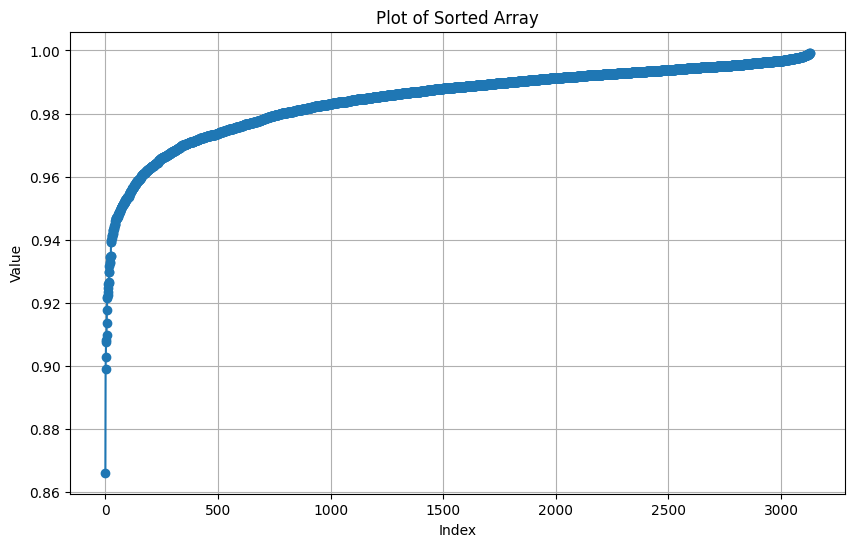

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_intersections, 'o-')
plt.title('Plot of Sorted Array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
arr = np.empty(0)
l1 = [2,3,4,5,6,5,3]
l2 = [2,3,4,5]
l3 = [2,3,]
arr = np.append(arr, l2)
arr = np.append(arr, l1)
arr

array([2., 3., 4., 5., 2., 3., 4., 5., 6., 5., 3.])

In [ ]:
all_intersections = np.empty(0)
target_boxes_count = []
for json_file_path in json_file_paths:
    if not json_file_path.exists():
        continue
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    txt_file_path = (segmentation_output_path /json_file_path.stem).with_suffix(".txt")

    if not class_file_path.exists():
        continue
    
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    
    if target_boxes.size == 0:
        continue 

    
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    former_segmentation_boxes = segmentation_boxes
    target_boxes = xcycwh2xyxy(target_boxes)
    target_boxes_count.append(len(target_boxes))
    
    box_matching_mask, iou_list = get_box_matching_mask(segmentation_boxes, target_boxes)

    box_indices_to_take = iou_list.argsort()[::-1][:len(target_boxes)]
 
    segmentation_boxes = segmentation_boxes[box_matching_mask][box_indices_to_take]
    
    segmentation_classes = target_classes[box_indices_to_take]
    segmentation_polygon = get_segmentation_polygon(json_file_path)
    
    all_intersections = np.append(all_intersections, iou_list) 
    all_intersections = np.sort(all_intersections)
    

print(all_intersections)

[0.86609308 0.89891743 0.90266454 ... 0.9991363  0.99915742 0.99928029]


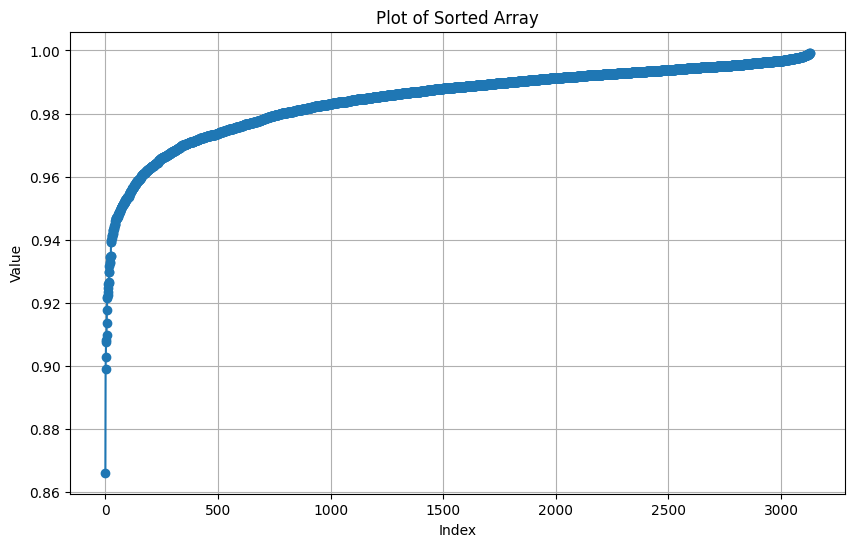

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_intersections, 'o-')
plt.title('Plot of Sorted Array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()